In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

import xgboost as xgb

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train_enc0.csv')
test = pd.read_csv('test_enc0.csv')

In [3]:
train.shape

(45718, 10)

In [4]:
test.shape

(11430, 9)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45718 entries, 0 to 45717
Data columns (total 10 columns):
0           45718 non-null float64
1           45718 non-null float64
2           45718 non-null float64
3           45718 non-null float64
4           45718 non-null float64
5           45718 non-null float64
6           45718 non-null float64
7           45718 non-null float64
PERID       45718 non-null int64
Criminal    45718 non-null int64
dtypes: float64(8), int64(2)
memory usage: 3.5 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 9 columns):
0        11430 non-null float64
1        11430 non-null float64
2        11430 non-null float64
3        11430 non-null float64
4        11430 non-null float64
5        11430 non-null float64
6        11430 non-null float64
7        11430 non-null float64
PERID    11430 non-null int64
dtypes: float64(8), int64(1)
memory usage: 803.8 KB


In [10]:
feature_names = [i for i in test.columns if i not in ['PERID']]

In [13]:
feature_names

['0', '1', '2', '3', '4', '5', '6', '7']

In [14]:
def modelfit(model, train_data, train_label, predictors, eval_metric, useTrainCV=True, cv_folds=10, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        params = {
            'objective' : xgb_param['objective'],
            'base_score' : xgb_param['base_score'],
            'colsample_bylevel' : xgb_param['colsample_bylevel'],
            'colsample_bytree' : xgb_param['colsample_bytree'],
            'gamma' : xgb_param['gamma'],
            'eta' : xgb_param['learning_rate'],
            'max_delta_step' : xgb_param['max_delta_step'],
            'max_depth' : xgb_param['max_depth'],
            'min_child_weight' : xgb_param['min_child_weight'],
            'alpha' : xgb_param['reg_alpha'],
            'lambda': xgb_param['reg_lambda'],
            'scale_pos_weight' : xgb_param['scale_pos_weight'],
            'subsample' : xgb_param['subsample'],     
        }
           
        dtrain = xgb.DMatrix(data=train_data[predictors], label=train_label)
        cvresult = xgb.cv(params , dtrain, num_boost_round=model.get_params()['n_estimators'], stratified=True, nfold=cv_folds, metrics=eval_metric, early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        # print(cvresult)
        print("########### n_estimators = %f" % cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(train_data[predictors], train_label,eval_metric=eval_metric)
        
    # Predict training set:
    train_predictions = model.predict(train_data[predictors])
    train_predprob = model.predict_proba(train_data[predictors])[:,1]
    
    # Predict X_valid set:
    #valid_predictions = model.predict(X_valid[predictors])
    #valid_predprob = model.predict_proba(X_valid[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("Accuracy score (Train): %.5g" % accuracy_score(train_label, train_predictions))
    print("precision score (Train): %.5g" % precision_score(train_label, train_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(train_label, train_predprob))
    # print("AUC Score (Validation): %f" % roc_auc_score(y_valid, valid_predprob))
    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return model

In [15]:
clf1 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, scale_pos_weight=(42543/3175))

########### n_estimators = 523.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.89562
precision score (Train): 0.39863
AUC Score (Train): 0.978583


<IPython.core.display.Javascript object>


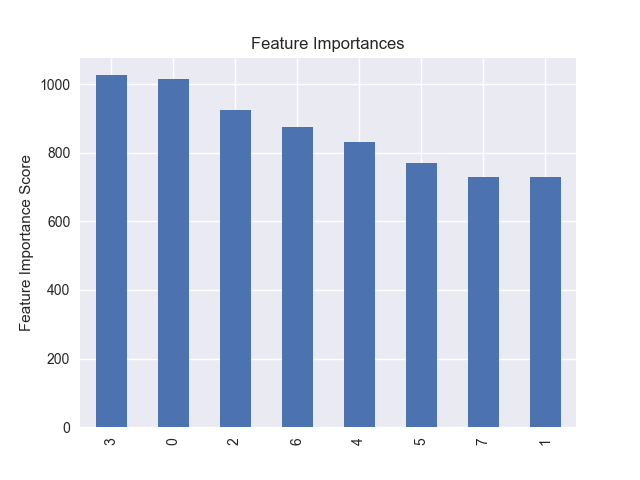

In [17]:
clf1 = modelfit(clf1, train, train['Criminal'], feature_names, 'auc')

In [18]:
pred1 = clf1.predict(test[feature_names])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
pd.Series(pred1).value_counts()

0    9447
1    1983
dtype: int64

In [21]:
confusion_matrix(train['Criminal'], clf1.predict(train[feature_names]))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[37806,  4737],
       [   35,  3140]])

In [22]:
sub = pd.DataFrame(columns = ['PERID', 'Criminal'])

In [23]:
sub['PERID'] = test['PERID']

In [24]:
sub['Criminal'] = pred1

In [26]:
sub.to_csv('aexgb0.csv', index=False, encoding='utf-8')

In [28]:
clf2 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0   

########### n_estimators = 523.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.89562
precision score (Train): 0.39863
AUC Score (Train): 0.978583


<IPython.core.display.Javascript object>


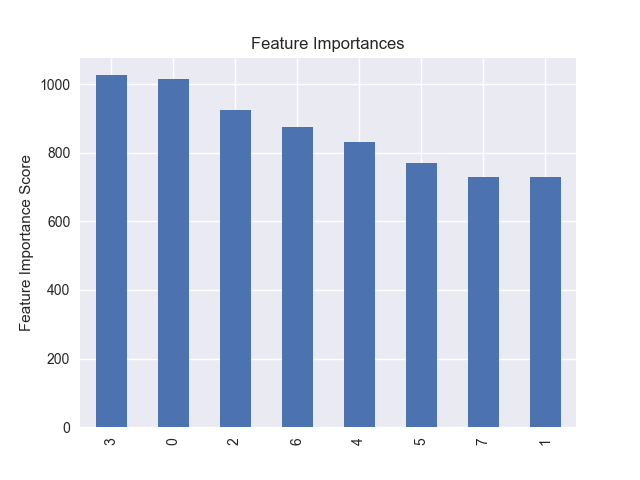

In [41]:
clf2 = modelfit(clf2, train, train['Criminal'], feature_names, 'logloss')

In [33]:
corr = train.corr()

<IPython.core.display.Javascript object>


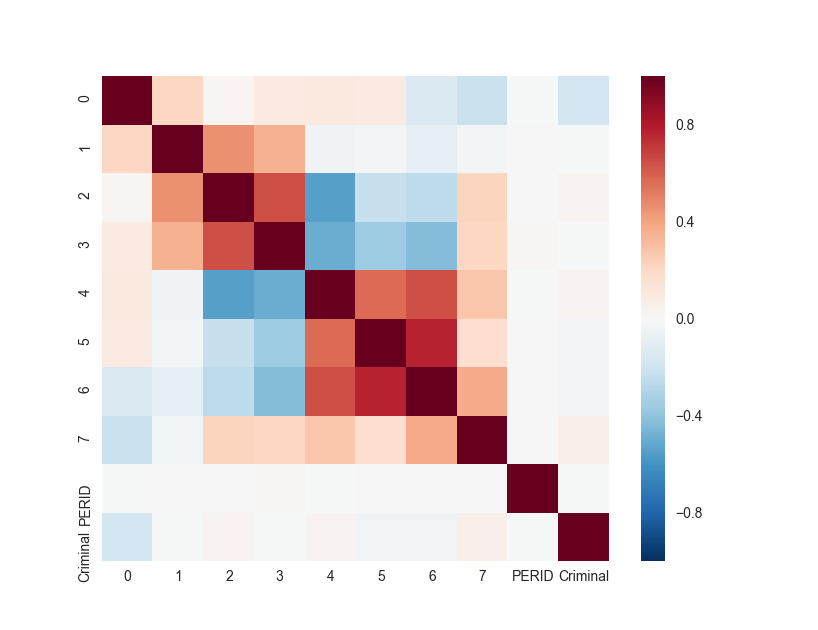

In [34]:
sns.heatmap(corr)

<IPython.core.display.Javascript object>


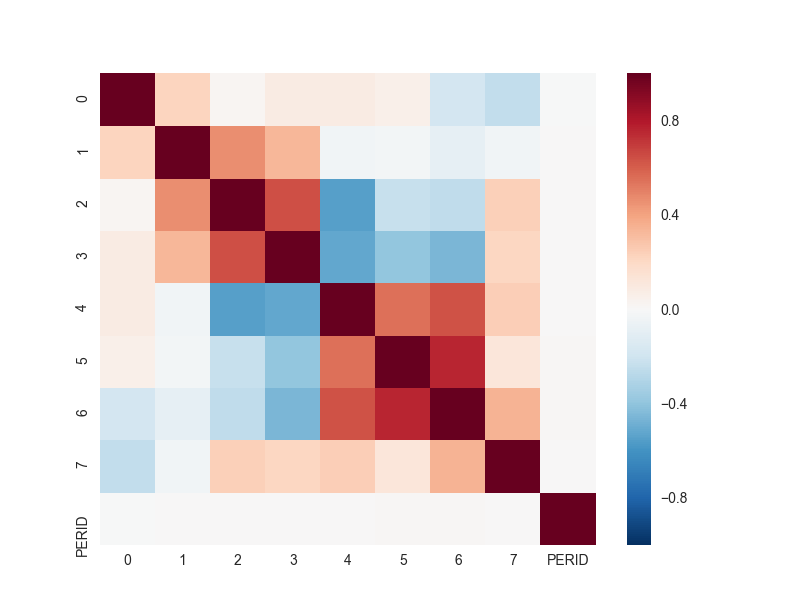

In [32]:
sns.heatmap(test.corr())

In [ ]:
oh_ae_data = pd.DataFrame(index=np.arange(0, 57148))

In [ ]:
for col in one_hot_columns:
    data = pd.get_dummies(all_data[col])
    oc = data.columns.tolist()
    fc = []
    for c in oc:
        fc.append(col + '#' +str(c))
    data.columns = fc
    oh_ae_data = oh_ae_data.join(data)

In [35]:
all_oh = pd.read_csv('all_oh.csv')

In [36]:
train_oh = all_oh[0: train.shape[0]]

In [37]:
test_oh = all_oh[train.shape[0] :]

In [38]:
train_oh.shape

(45718, 402)

In [39]:
train.shape

(45718, 10)

In [42]:
train_oh['Criminal'] = train['Criminal']

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
feature_names1 = [i for i in train_oh.columns if i not in ['Criminal']]

In [45]:
len(feature_names1)

402

In [47]:
clf3 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, scale_pos_weight=(42543/3175) )   

########### n_estimators = 1000.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.94895
precision score (Train): 0.57641
AUC Score (Train): 0.994090


<IPython.core.display.Javascript object>


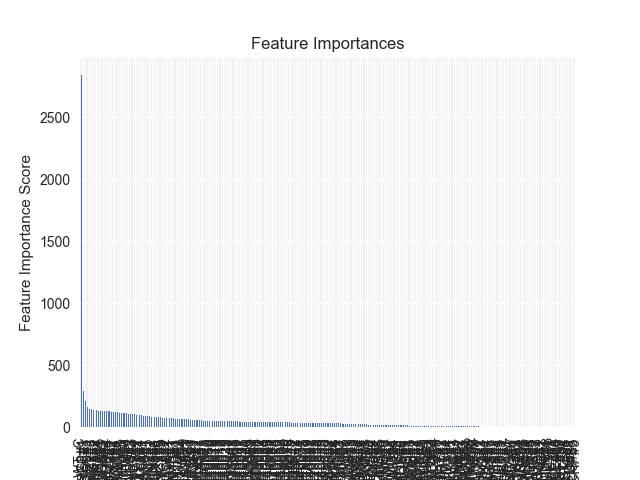

In [48]:
clf2 = modelfit(clf3, train_oh, train_oh['Criminal'], feature_names1, 'logloss')